In [1]:
# metmast signals
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
import inspect
import scipy as sp

import total_var_functions as TV

%load_ext autoreload
%autoreload 2

In [2]:
#######################################
def total_variation(data,
                    blocksize=60,
                    detrend=None,
                    column=None,
                    window='slide',
                    fitcurve=None
                   ):
    '''
    Calculate the total variation of a dataset.
    Data is cut into blocks sequentially (window='block') or with a
    sliding window (window='slide'). 
    

    Parameters
    ----------
    data: df.DataFrame, np.ndarray
        input data of format (timeseries x datachannels)

    blocksize: int
        size of blocks for which to calculate total variation
        blocksize reflects the duration of each period in minutes

    detrend: None, list
        list of variables to detrend (linear)
        
    column: str
        name of column to detrend
    
    window: str
        'block' - sequential, non overlapping windows
        'slide' - overlapping windows of length 'blocksize' at each index

    fitcurve: str
        specify the fit function to use for detrending.
    
    Returns
    --------
    totalvar: df.Series
        Series of the total variation for each time period.
    '''

    if window == 'slide':
        timeind = data.index
    elif window == 'block':
        # make new time index (hourly)
        timeind = pd.DatetimeIndex(start=data.index[0],
                                   freq='{}T'.format(blocksize),
                                   end=data.index[-1])

    nblocks = len(timeind) 

    # allocate space for totalvar
    totalvar = np.zeros(nblocks)

    # if detrending data, parse objective functino, and the number of required arguments
    if detrend is not None:
        fitfunc, param_names = TV.parse_fitfunc(detrend)
        param_names.append('residual')
        tmp = inspect.getfullargspec(fitfunc)
        nargs = len(tmp.args)
        fits = np.zeros((nblocks, nargs))  # slope, offset, residual
        x = np.arange(blocksize)

    nskip = 0
    timedelay = pd.Timedelta('{}m'.format(blocksize - 1))

    # loop over data blocks
    for ii in range(nblocks - 1):

        startind = timeind[ii]
        endind = startind + timedelay

        block = data[startind:endind].dropna(how='any').copy()
        # block = data.iloc[startind:startind + blocksize].copy()

        if (len(block) < blocksize) | (any(block.std() == 0)) | (
            (np.abs(block.wdir.diff()).max() > 60)):
            nskip += 1
            continue

        if detrend is not None:
            p0 = TV.parse_init_fitvals(detrend, block[column].values)

            # try to make a good fit. Sometimes it just doesn't go well...
            try:
                fittest = sciop.curve_fit(fitfunc, x, block[column], p0)
                fitparams, _ = fittest
                fitcurve = fitfunc(x, *fitparams)
                residual = np.linalg.norm(block[column] -
                                          fitfunc(x, *fitparams))**2
            except:
                # print('excepted')
                fitparams = p0
                fitcurve = fitfunc(x, *fitparams)
                residual = np.nan
                # fits[ii, :] = np.nan
                # continue

            block[column] -= (fitcurve + block[column].mean())
            fits[ii, :-1] = fitparams
            fits[ii, -1] = np.linalg.norm(residual)

        totalvar[ii] = TV.covdet(block)

    # make dataframe for total variation
    totalvar = pd.DataFrame(data=totalvar, index=timeind, columns=['totalvar'])

    # if data has been detrended, add fit parameter columns to output dataframe
    if detrend is not None:

        fitcols = {'_'.join([column, x]): np.array([]) for x in param_names}
        fits = pd.DataFrame(index=totalvar.index, data=fits, columns=fitcols)
        totalvar = totalvar.join(fits)

#     # replace 0.0 with np.nan
#     totalvar.replace(0, np.nan, inplace=True)
#     # Drop all nan values
#     totalvar.dropna(inplace=True, how='any')

    return totalvar

## Load meteorological data

In [3]:
#### read pre-processed data.
metdf = pd.read_csv('../../../data/metdata_2009.csv')
metdf.dropna(how='any', inplace=True)
metdf.index = pd.DatetimeIndex(metdf['time'])
metdf.drop(labels=['time'], axis=1, inplace=True)

# standardize data
metdfnorm = TV.standardize_data(metdf)

In [4]:
tvar = total_variation(metdfnorm, blocksize=200, window='block')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:49: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.


In [5]:
tvarLinear = total_variation(metdfnorm, 
                       blocksize=200, 
                       window='block', 
                       detrend='linear', 
                       column='wspd')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:49: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.


In [6]:
tvarLinear.head()

,totalvar,wspd_slope,wspd_offset,wspd_residual
2009-03-23 00:00:00,0.000003,0.001165,2.967553,NaN
2009-03-23 03:20:00,0.000002,-0.004691,2.359922,NaN
2009-03-23 06:40:00,0.000010,-0.007568,0.810756,NaN
2009-03-23 10:00:00,0.000002,-0.001323,0.203364,NaN
2009-03-23 13:20:00,0.000105,-0.003598,-0.718159,NaN


In [33]:
tvar.shape

(1920, 1)

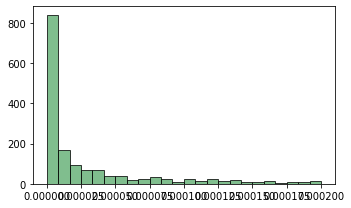

In [13]:
fig, ax = plt.subplots(figsize=(5,3))
ax.hist(tvar, bins=np.linspace(0,0.0002, 25), edgecolor='k', facecolor='C0', alpha=0.75,)
ax.hist(tvarLinear['totalvar'], bins=np.linspace(0,0.0002, 25), edgecolor='k', facecolor='C1', alpha=0.75, )
fig.tight_layout()

### Mahalanobis distance

True Mahalanobis distance:

$$MD = \sqrt{(x-\mu)^T C^{-1} (x-\mu)}$$

where $x$ is the input data, and $\mu$ is the center of the data determined as the mean along each coodinate variable. In reality, there are a finite number of observations of $x$ and the mean and covariance matrix must be estimated,

$$MD = \sqrt{(x-\hat{\mu})^T \hat{C}^{-1} (x-\hat{\mu})}$$

([array([  2.,   0.,   5.,   2.,   6.,  23.,  34.,  26.,  53.,  48.,  86.,
          81., 101., 112.,  92.,  90.,  79.,  43.,  45.,  37.,  16.,   6.,
           9.,   4.]),
  array([  0.,   0.,   1.,   6.,  11.,  17.,  26.,  29.,  46.,  64.,  74.,
          97.,  99., 108.,  86.,  96.,  83.,  57.,  38.,  28.,  14.,  12.,
           5.,   2.])],
 array([-0.9298396 , -0.8594125 , -0.78898541, -0.71855832, -0.64813123,
        -0.57770414, -0.50727705, -0.43684995, -0.36642286, -0.29599577,
        -0.22556868, -0.15514159, -0.08471449, -0.0142874 ,  0.05613969,
         0.12656678,  0.19699387,  0.26742097,  0.33784806,  0.40827515,
         0.47870224,  0.54912933,  0.61955642,  0.68998352,  0.76041061]),
 <a list of 2 Lists of Patches objects>)

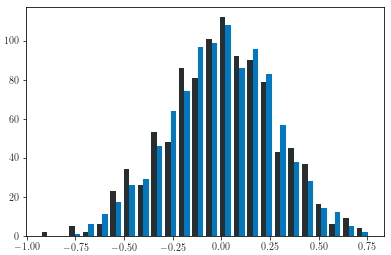

In [68]:
shape_factor = np.random.rand(2)
scale = np.random.rand(1)*100
rotation_angle = np.random.rand(1)*2*np.pi
rotation_matrix = np.array([[np.cos(rotation_angle), np.sin(rotation_angle)],[np.sin(rotation_angle), -np.cos(rotation_angle)]]).squeeze()

synthetic_data = standardize_data(np.random.normal(size=(datasize,2), scale=scale), interval=np.array([-1,1]))
synthetic_data = np.matmul(synthetic_data*shape_factor, rotation_matrix)
plt.hist(synthetic_data)

In [69]:
outlier_error = np.zeros(10000)
noutliers = outlier_error.copy()
t = outlier_error.copy()
tc = outlier_error.copy()
datasize = 1000

for ii in range(len(outlier_error)):
    
    shape_factor = np.random.rand(2)
    scale = np.random.rand(1)*100
    rotation_angle = np.random.rand(1)*2*np.pi
    rotation_matrix = np.array([[np.cos(rotation_angle), np.sin(rotation_angle)],[np.sin(rotation_angle), -np.cos(rotation_angle)]]).squeeze()

    synthetic_data = lf.normalize_data(np.random.normal(size=(datasize,2), scale=scale), interval=np.array([-1,1]))
    synthetic_data = np.matmul(synthetic_data*shape_factor, rotation_matrix)
    clean_data, outliers, outlier_index = lf.find_outliers(synthetic_data, searchtype='mahal')

    t[ii], v, s = lf.pca_var(synthetic_data)
    tc[ii], vc, sc = lf.pca_var(clean_data)
    
    noutliers[ii] = len(outlier_index)
    outlier_error[ii] = (t[ii]-tc[ii])/t[ii]

../scripts/Lillgrund_funcs.py:826: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(np.dot(np.dot((data - center), VI), (data - center).T)))


In [332]:
# outlier_error = np.zeros(10000)
# noutliers = outlier_error.copy()
# datasize = 1000

# for ii in range(len(outlier_error)):
    
#     shape_factor = np.random.rand(2)
#     rotation_angle = np.random.rand(1)*2*np.pi
#     rotation_matrix = np.array([[np.cos(rotation_angle), np.sin(rotation_angle)],[np.sin(rotation_angle), -np.cos(rotation_angle)]]).squeeze()

#     synthetic_data = lf.normalize_data(np.random.normal(size=(datasize,2)), interval=np.array([-1,1]))
#     synthetic_data = np.matmul(synthetic_data*shape_factor, rotation_matrix)
#     clean_data, outliers, outlier_index = lf.find_outliers(synthetic_data, searchtype='mahal')

#     t, v, s = lf.pca_var(synthetic_data)
#     tc, vc, sc = lf.pca_var(clean_data)
    
#     noutliers[ii] = len(outlier_index)
#     outlier_error[ii] = (t-tc)/t

../scripts/Lillgrund_funcs.py:608: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(np.dot(np.dot((data - center), VI), (data - center).T)))


In [70]:
dfout = pd.DataFrame(data=np.vstack([noutliers, outlier_error]).T, columns=['n_outliers', 'error'])

outlier_stats = dfout.groupby('n_outliers').describe()

outlier_stats.columns = ['_'.join(col).strip() for col in outlier_stats.columns.values]

In [71]:
outlier_stats

,error_count,error_mean,error_std,error_min,error_25%,error_50%,error_75%,error_max
n_outliers,,,,,,,,
1.0,1.0,0.005027,NaN,0.005027,0.005027,0.005027,0.005027,0.005027
2.0,6.0,0.012102,0.005429,0.005444,0.009287,0.011026,0.014300,0.021020
3.0,25.0,0.009556,0.005981,-0.000843,0.003485,0.012497,0.013476,0.017705
4.0,58.0,0.017544,0.006750,-0.000866,0.013900,0.017914,0.022084,0.033659
5.0,148.0,0.023392,0.006662,0.009393,0.019443,0.022350,0.027104,0.043359
6.0,316.0,0.026972,0.006714,0.010121,0.022971,0.026869,0.030524,0.051415
7.0,579.0,0.031278,0.008124,0.001312,0.026167,0.031321,0.036135,0.060397
8.0,839.0,0.035869,0.008663,0.006606,0.030642,0.035957,0.040822,0.069441
9.0,1191.0,0.040506,0.009262,0.010418,0.035188,0.040621,0.045847,0.077727


### Scatter plot of a single sample of synthetic data

In [2]:
datasize=1000

shape_factor = [1,1/3]# np.random.rand(2)
# scale = np.random.rand(1)*40
rotation_angle = [40]#np.random.rand(1)*2*np.pi
rotation_matrix = np.array([[np.cos(rotation_angle), np.sin(rotation_angle)],[np.sin(rotation_angle), -np.cos(rotation_angle)]]).squeeze()

synthetic_data = lf.normalize_data(np.random.normal(size=(datasize,2), scale=scale), interval=np.array([-1,1]))
synthetic_data = np.matmul(synthetic_data*shape_factor, rotation_matrix)
clean_data, outliers, outlier_index = lf.find_outliers(synthetic_data, searchtype='mahal')

fig,ax = plt.subplots(figsize=(5,3))
ax, scat,_,_ = lf.condition_scatter(synthetic_data, ax=ax)
scat.set_alpha(0.75)
outs = ax.scatter(outliers[:,0], outliers[:,1], facecolor='C2', edgecolor='k', alpha=0.75)
ax.axis([-0.8,0.8,-0.8,0.8])
ax.set_aspect('equal')
ax.set_xlabel('Normalized Data')
ax.set_ylabel('Normalized Data')
ax.legend([scat, outs], ['Data', 'Outlier'], frameon=True, edgecolor='k')#, loc=3)
# fig.savefig(os.path.join('figs/data_w_outliers.pdf'))

NameError: name 'lf' is not defined

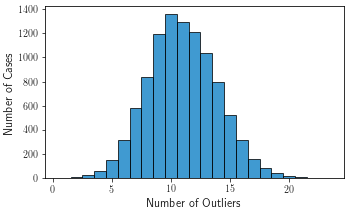

In [73]:
fig, ax = plt.subplots(figsize=(5,3))
ax.bar( outlier_stats.index, outlier_stats.error_count, facecolor='C1', edgecolor='k', alpha=0.75, width=1, linewidth=1)
ax.set_xlabel('Number of Outliers')
ax.set_ylabel('Number of Cases')
fig.savefig(os.path.join(figpath,'outliers_by_dummy_case.pdf'))

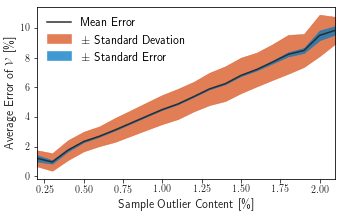

In [85]:
fig, ax = plt.subplots(figsize=(5,3))
xdata = outlier_stats.index/datasize*100

ax.plot(xdata, 100*outlier_stats.error_mean)

upper_error = 100*(outlier_stats.error_mean + outlier_stats.error_std)
lower_error = 100*(outlier_stats.error_mean - outlier_stats.error_std)
ax.fill_between(xdata, upper_error, lower_error, color='C2', alpha=0.75)

upper_error = 100*(outlier_stats.error_mean + outlier_stats.error_std/np.sqrt(outlier_stats.error_count))
lower_error = 100*(outlier_stats.error_mean - outlier_stats.error_std/np.sqrt(outlier_stats.error_count))
ax.fill_between(xdata, upper_error, lower_error, color='C1', alpha=0.75)

ax.set_xlabel('Sample Outlier Content [\%]')
ax.set_ylabel(r'Average Error of $\mathcal{V}$ [\%]')
ax.set_xlim([200/datasize,2100/datasize])

ax.legend(['Mean Error', r'$\pm$ Standard Devation', r'$\pm$ Standard Error'])
fig.savefig(os.path.join('figs/outliers_average_error.pdf'))

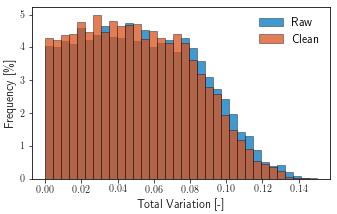

In [77]:
fig,ax = plt.subplots(figsize=(5,3))
bins = np.linspace(0,0.15,35)

ax.hist(t, bins=bins, facecolor='C1', alpha=0.75, edgecolor='k', weights=np.ones(len(t))/len(t)*100)
ax.hist(tc, bins=bins, facecolor='C2', alpha=0.75, edgecolor='k', weights=np.ones(len(t))/len(t)*100)
ax.legend(['Raw', 'Clean'])

ax.set_xlabel(r'Total Variation [-]')
ax.set_ylabel(r'Frequency [\%]')

fig.savefig(os.path.join('figs/tvar_dummy_data.pdf'))